# Threshold Optimization for Linear Regression


Given one feature, logistic regression will output a probability, p, with respect to the target variable. If p is greater than 0.5, we label the data as '1'; if p is less than 0.5, we label it '0'. Here 0.5 is our default threshold. 

Now, what happens as we vary this threshold?
In particular, what happens to the true positive and false positive rates as we vary the threshold?

When the threshold equals zero, the model predicts '1' for all the data, which means the true positive rate is equal to the false positive rate is equal to one. When the threshold equals '1', the model predicts '0' for all data, which means that both true and false positive rates are 0. If we vary the threshold between these two extremes, we get a series of different false positive and true positive rates.
The set of points we get when trying all possible thresholds is called the receiver operating characteristic curve or ROC curve.

In [5]:
#Import the necassary packages
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load the Boston House dataset
from sklearn.datasets import load_boston

In [7]:
# Load the Logistic Regressor with StandardScaler and make_pipeline. We will get to their uses below
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [34]:
# Import train_test_split and cross_val_score with roc_curve, plot_roc_curve, and balanced_accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,plot_roc_curve, balanced_accuracy_score

In [35]:
# Declare the X and y variables.
# load_boston is a package and contains a function return_X_y to directly declare X and y
X,y = load_boston(return_X_y=True)

We can now convert boston dataset into a binary classification problem creating a new target whose values is 1 if the original target value is greater than the mean value, 0 otherwise. Finally, we’ll split the dataset into training and test sets.

In [36]:
y = (y > y.mean()).astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We can now create our logistic regression pipeline along with a StandardScaler and fit it.

In [38]:
model = make_pipeline(StandardScaler(),LogisticRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [51]:
pred = model.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[102   4]
 [ 11  50]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       106
           1       0.93      0.82      0.87        61

    accuracy                           0.91       167
   macro avg       0.91      0.89      0.90       167
weighted avg       0.91      0.91      0.91       167



We can see that the accuracy is 91%. Let us now tune this with the ROC curve.

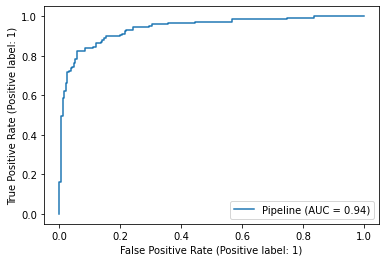

In [40]:
plot_roc_curve(model,X_train,y_train)

ROC is a method of tuning the threshold which helps us identify that threshold that gives us the upper-left corner of the curve. Mathematically speaking, that threshold p that satisfies the equation:
TPR(p) = 1-FPR(p)

we can calculate all the scores generated by our model and find the one that minimizes the argument above using the following code:

In [41]:
fpr, tpr, thresholds = roc_curve(y_train,model.predict_proba(X_train)[:,1],drop_intermediate=False)

We can plot the objective function with respect to the threshold and see where its minimum is.

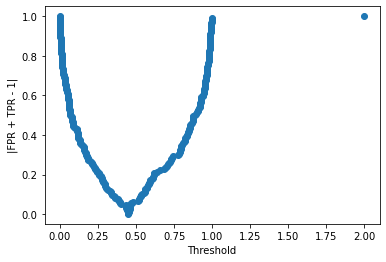

In [42]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

We have a minimum that is visibly  before 0.5. We can find the correct value using the code snippet below

In [43]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.4462568560243526

Now that we know the threshold is 0.44, lets try to use the regression model with the new threshold

In [47]:
THRESHOLD = 0.446
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [50]:
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[94 12]
 [ 8 53]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       106
           1       0.82      0.87      0.84        61

    accuracy                           0.88       167
   macro avg       0.87      0.88      0.87       167
weighted avg       0.88      0.88      0.88       167



Although this is the threshold we want, we can observe that the original confusion matrix had lesser wrong predictions and more accuracy.
Another approach we can follow is to find the threshold that maximizes the accuracy by using balanced accuracy because it takes into account a possible unbalanced dataset.

We first run through all the scores and store the accuracies in a list. Then we plot them.

In [52]:
threshold = []
accuracy = []

for p in np.unique(model.predict_proba(X_train)[:,1]):
  threshold.append(p)
  y_pred = (model.predict_proba(X_train)[:,1] >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_train,y_pred))

Now plotting the revised curve

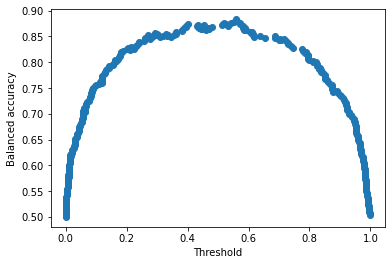

In [53]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

Here, we can see that the maximum is visibly between 0.4 and 0.6

Let us find what the maximum value is in the range 0.4 to 0.6

In [55]:
threshold[np.argmax(accuracy)]

0.5602892029099028

The threshold producing the maximum accuracy is 0.56

In [61]:
THRESHOLD = 0.56
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [62]:
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[103   3]
 [ 12  49]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       106
           1       0.94      0.80      0.87        61

    accuracy                           0.91       167
   macro avg       0.92      0.89      0.90       167
weighted avg       0.91      0.91      0.91       167



As shown, the prediction accuracy is 91%.